File berhasil diekstrak.
Found 2527 images belonging to 6 classes.
Found 2527 images belonging to 6 classes.
Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 170s 2s/step - accuracy: 0.4801 - loss: 1.3932 - val_accuracy: 0.7796 - val_loss: 0.5854 - learning_rate: 0.0010
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.7086 - loss: 0.7573 - val_accuracy: 0.8374 - val_loss: 0.4608 - learning_rate: 0.0010
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.7735 - loss: 0.6105 - val_accuracy: 0.8627 - val_loss: 0.3858 - learning_rate: 0.0010
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.8105 - loss: 0.5225 - val_accuracy: 0.8777 - val_loss: 0.3575 - learning_rate: 0.0010
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.8144 - loss: 0.4951 - val_accuracy: 0.9003 - val_loss: 0.3086 - learning_rate: 0.0010
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.8299 - loss: 0.4745 - val_accuracy: 0.8896 - val_loss: 0.2972 - learnin

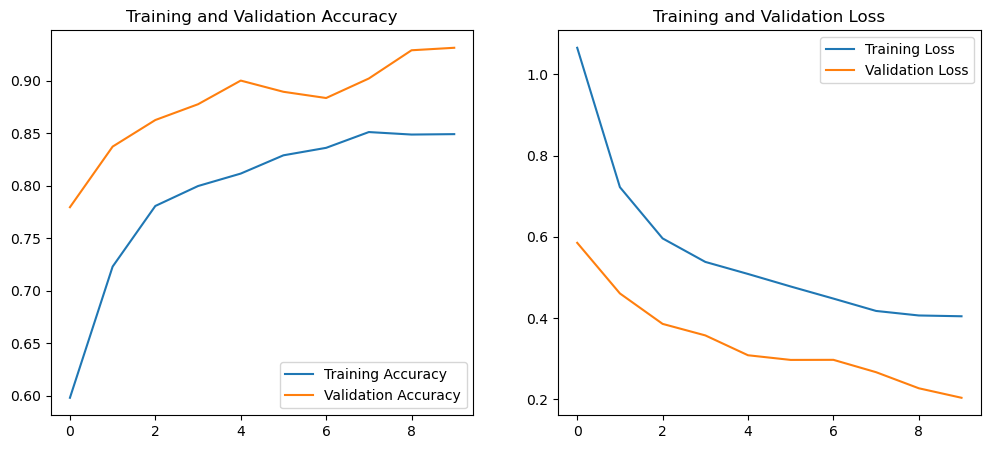

In [10]:
import os
import zipfile
import gdown
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import sys
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
from PyQt5.QtWidgets import QApplication, QFileDialog

# ==============================
# 📁 Download & Extract Dataset
# ==============================
dataset_zip_path = r"C:\Users\zidan\Desktop\Coding\PYTHON\garbage_classification.zip"
if os.path.exists(dataset_zip_path):
    try:
        with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
            zip_ref.extractall('garbage_classification')
        print("File berhasil diekstrak.")
    except zipfile.BadZipFile:
        print("File tidak valid atau bukan file ZIP.")
else:
    print("File tidak ditemukan atau tidak valid.")


# ==============================
# 📊 Data Preprocessing
# ==============================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

dataset_path = r"C:\Users\zidan\Desktop\Coding\PYTHON\garbage_classification"

train_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_path, 'train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    os.path.join(dataset_path, 'validation'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# ==============================
# 🤖 Model Building (MobileNetV2)
# ==============================
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(6, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# ==============================
# 🧠 Callbacks
# ==============================
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# ==============================
# 📈 Model Training
# ==============================
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

# ==============================
# 📊 Evaluate & Plot Results
# ==============================
def plot_learning_curve(history):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    plt.show()

plot_learning_curve(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


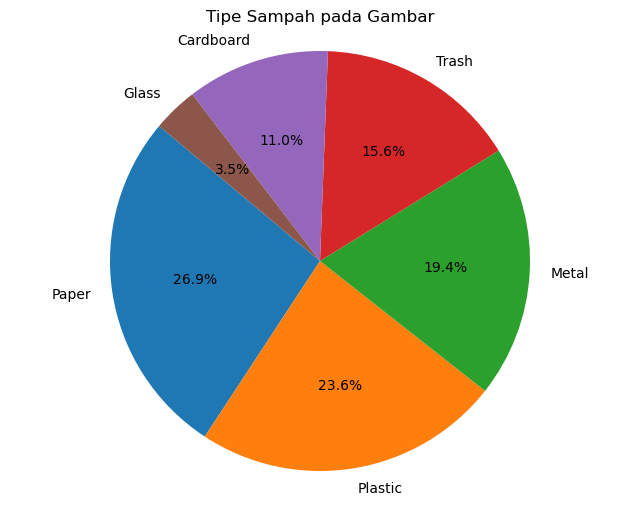

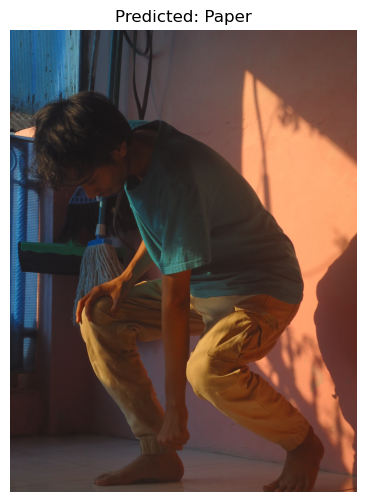

In [18]:
# ==============================
# 🖼️ Image Prediction Function
# ==============================
model = load_model('best_model.keras')

class_names = ["Cardboard", "Glass", "Metal", "Paper", "Plastic", "Trash"]

def detect_and_classify_trash(image):
    resized_image = cv2.resize(image, (224, 224))
    normalized_image = resized_image.astype("float") / 255.0
    input_image = np.expand_dims(normalized_image, axis=0)
    
    predictions = model.predict(input_image)
    predicted_class_indices = np.argmax(predictions, axis=1)
    class_predictions = {class_names[i]: predictions[0][i] for i in range(len(class_names))}
    sorted_predictions = sorted(class_predictions.items(), key=lambda x: x[1], reverse=True)
    
    # Pie Chart
    labels = [class_name for class_name, _ in sorted_predictions]
    scores = [score for _, score in sorted_predictions]
    
    plt.figure(figsize=(8, 6))
    plt.pie(scores, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.title('Tipe Sampah pada Gambar')
    plt.show()
    
    # Display Image
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f'Predicted: {labels[0]}')
    plt.axis('off')
    plt.show()

def select_image():
    app = QApplication(sys.argv)
    file_path, _ = QFileDialog.getOpenFileName(None, "Pilih Gambar", "", "Image Files (*.png;*.jpg;*.jpeg;*.bmp)")
    
    if file_path:
        image = cv2.imread(file_path)
        if image is None:
            print(f"Failed to load image from {file_path}")
            return
        detect_and_classify_trash(image)
    
    app.quit()

# Jalankan untuk memilih gambar
if __name__ == '__main__':
    select_image()